In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

### Figure

Load source data, generate figure

In [3]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results'
BF_RESULTS_ROOT = RESULTS_ROOT / 'Bengalese_Finches' / 'learncurve'
CANARY_RESULTS_ROOT = RESULTS_ROOT / 'Canaries' / 'learncurve'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'figures'

In [4]:
THIS_FIG_ROOT = fname = FIGS_ROOT / 'mainfig_across_individuals_species'
THIS_FIG_ROOT.mkdir(exist_ok=True)

In [5]:
CLEANUPS = (
    'none',
    'min_segment_dur_majority_vote'
)

In [6]:
bf_curve_df = pd.read_csv(THIS_FIG_ROOT / f'fig4-data1.csv')
canary_curve_df = pd.read_csv(THIS_FIG_ROOT / f'fig4-data2.csv')

### Main figure.

In [7]:
PALETTE_COLORBLIND = sns.color_palette('colorblind')  # note: defaults to 10 colors

SPECIES_PALETTE_MAP = {
    'Bengalese Finch': PALETTE_COLORBLIND[4],
    'Canary': PALETTE_COLORBLIND[7],
}

PALETTE_PASTEL = sns.color_palette('pastel')  # note: defaults to 10 colors
ANIMAL_ID_PALETTE_MAP = {
    'Bengalese Finch': PALETTE_PASTEL[6],
    'Canary': PALETTE_PASTEL[7],
}


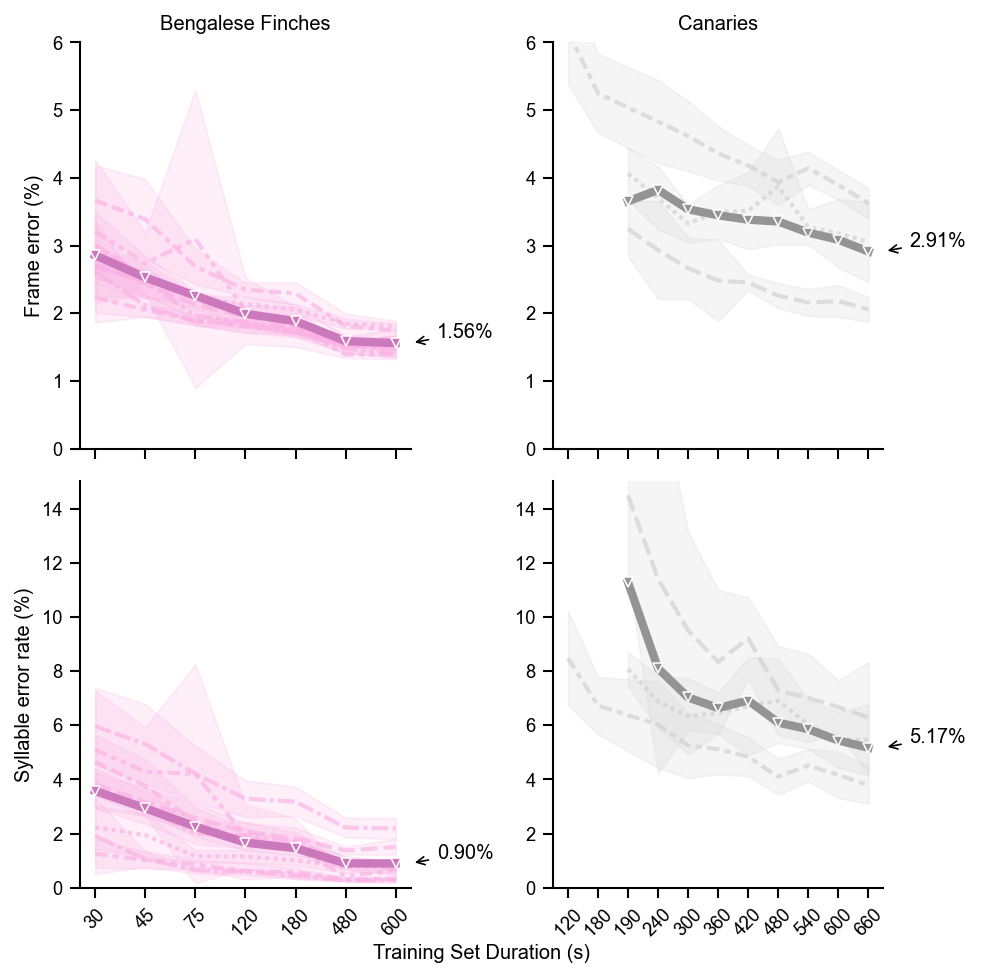

In [8]:
sns.set_context("paper", font_scale=1)

# make figure instance
FIGSIZE = (7, 7)
DPI = 150

NROWS = 2  # frame error rate, syllable error rate
NCOLS = 2  # Bengalese finches, Canaries

fig, ax_arr = plt.subplots(
    #constrained_layout=True,
    NROWS, NCOLS,
    figsize=FIGSIZE, 
    dpi=DPI
                )

# set up for loop
CLEANUP = 'min_segment_dur_majority_vote'

metrics = [
    'avg_error', 
    'avg_segment_error_rate',
]

cleanups = [
    CLEANUP,
    CLEANUP,
]

ylabels = [
    'Frame error (%)', 
    'Syllable error rate (%)', 
]

LEGEND = False

for col, (col_title, curve_df) in enumerate(
    zip(
        ['Bengalese Finches', 'Canaries'],
        [bf_curve_df, canary_curve_df],
    )
):
    animal_ids_uniq = curve_df.animal_id.unique()
    dashes = sns._core.unique_dashes(len(animal_ids_uniq) + 1)[1:]  # don't use solid line, which is first returned by `unique_dashes`
    animal_id_dashes = dict(zip(animal_ids_uniq, dashes))
    
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    for metric, cleanup, ylabel in zip(metrics, cleanups, ylabels):
        if metric == 'avg_error':
            row = 0
        elif metric == 'avg_segment_error_rate':
            row = 1

        ax = ax_arr[row, col]

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]
        if metric == 'avg_segment_error_rate' and cleanup == 'none':
            pass
        else:
            sns.lineplot(x='train_set_dur_ind', 
                         y=metric, 
                         style='animal_id',
                         hue='species',
                         data=curve_df_cleanup,
                         ci='sd',
                         palette=ANIMAL_ID_PALETTE_MAP,
                         linewidth=2,
                         dashes=animal_id_dashes,
                         ax=ax, 
                         legend=LEGEND,
                         alpha=0.65)

        if col_title == 'Canaries':
            # only plot mean for training set durations where we have results for all birds, which is > 180
            curve_df_for_mean = curve_df_cleanup[curve_df_cleanup.train_set_dur > 180]
        else:
            curve_df_for_mean = curve_df_cleanup

        if metric == 'avg_segment_error_rate' and cleanup == 'none':
            alpha = 0.75
        else:
            alpha = 1.0

        g = sns.lineplot(x='train_set_dur_ind',
                         y=metric, 
                         linestyle='solid',
                         hue='species',
                         palette=SPECIES_PALETTE_MAP,
                         linewidth=4, 
                         data=curve_df_for_mean,
                         ci=None,
                         ax=ax,
                         marker='v',
                         alpha=alpha,
                         legend=LEGEND)

        mean_acc_max_dur = curve_df_for_mean[
            curve_df_for_mean.train_set_dur == curve_df_for_mean.train_set_dur.max()
        ][metric].mean()

        if col == 0:
            ylabel_text = ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')

        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        if row == NROWS - 1:
            ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)
        else:
            ax.set_xticklabels([])

        ax.annotate(f'{mean_acc_max_dur:0.2f}%',
                    xy=(ax.get_xlim()[-1], mean_acc_max_dur), 
                    xycoords='data',
                    xytext=(12.5, 5), 
                    textcoords='offset points',
                    verticalalignment='center',
                    arrowprops=dict(arrowstyle="->", facecolor='black'),
                    annotation_clip=False)

            
        if row == 0:
            title_text = ax.set_title(col_title)  # use Text instance below for 'big panel axis'

# zoom-in / limit the view to different portions of the data
for ax in ax_arr[0, :]:
    ax.set_ylim(0, 6)
for ax in ax_arr[1, :]:
    ax.set_ylim(0, 15)

for ax in ax_arr.flatten():
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)

    
# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

# use Text instance from above so that this label is the same size as the axes titles
#title_fontsize = title_text.get_size()  # , fontsize=title_fontsize
big_ax.set_xlabel("Training Set Duration (s)", labelpad=10);
       
fig.tight_layout()

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'error-curves-across-individuals-species.{ext}',
        bbox_inches='tight',
    )